# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pyabc
import logging

pyabc.settings.set_figure_params('pyabc')  # for beautified plots


# for debugging
df_logger = logging.getLogger('ABC.Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * np.random.normal(),
            'ss2': 2 + 10 * np.random.normal()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-05-09 23:19:14.061509>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.46976544e+00.
ABC INFO: Accepted: 100 / 259 = 3.8610e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 4.32733144e+00.
ABC INFO: Accepted: 100 / 442 = 2.2624e-01, ESS: 9.7254e+01.
ABC INFO: t: 2, eps: 2.66881742e+00.
ABC INFO: Accepted: 100 / 599 = 1.6694e-01, ESS: 9.7103e+01.
ABC INFO: t: 3, eps: 1.82582426e+00.
ABC INFO: Accepted: 100 / 1176 = 8.5034e-02, ESS: 9.8983e+01.
ABC INFO: t: 4, eps: 1.32332597e+00.
ABC INFO: Accepted: 100 / 1606 = 6.2267e-02, ESS: 9.9000e+01.
ABC INFO: t: 5, eps: 9.97047341e-01.
ABC INFO: Accepted: 100 / 2143 = 4.6664e-02, ESS: 9.9809e+01.
ABC INFO: t: 6, eps: 6.77771056e-01.
ABC INFO: Accepted: 100 / 2777 = 3.6010e-02, ESS: 9.7650e+01.
ABC INFO: t: 7, eps: 4.62783743e-01.
ABC INFO: Accepted: 100 / 4958 = 2.0169e-02, ESS: 9.8978e+01.
ABC INFO: Stop: Maximum number of generati

Let us visualize the results for the non-adaptive distance:

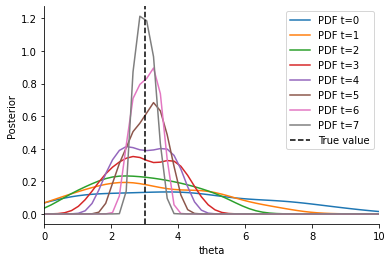

In [3]:
# plotting

def plot_history(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot_history(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.UniformAcceptor(use_complete_history=True))

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-05-09 23:19:24.096337>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Weights[0] = {'ss1': 1.5038123509886183, 'ss2': 0.4961876490113815}
ABC INFO: t: 0, eps: 6.31022315e+00.
ABC INFO: Accepted: 100 / 208 = 4.8077e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Weights[1] = {'ss1': 1.5282050824812858, 'ss2': 0.47179491751871416}
ABC INFO: t: 1, eps: 3.65229708e+00.
ABC INFO: Accepted: 100 / 235 = 4.2553e-01, ESS: 9.9624e+01.
ABC.Distance DEBUG: Weights[2] = {'ss1': 1.686257325545598, 'ss2': 0.3137426744544022}
ABC INFO: t: 2, eps: 2.25802582e+00.
ABC INFO: Accepted: 100 / 387 = 2.5840e-01, ESS: 9.9809e+01.
ABC.Distance DEBUG: Weights[3] = {'ss1': 1.78909941117397, 'ss2': 0.21090058882602988}
ABC INFO: t: 3, eps: 1.26392327e+00.
ABC INFO: Accepted: 100 / 367 = 2.7248e-01, ESS: 9.9068e+01.
ABC.Distance DEBUG: Weights[4] = {'ss1': 1.8619256105799944, 'ss2': 0.13807438942000547}

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``use_complete_history=True`` in order to get nested acceptance regions. It means that also all previous acceptance criteria are re-applied. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

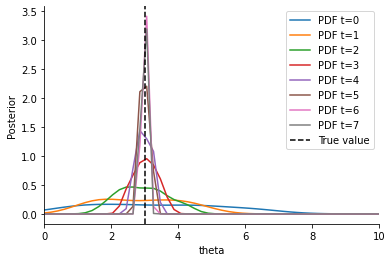

In [5]:
plot_history(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

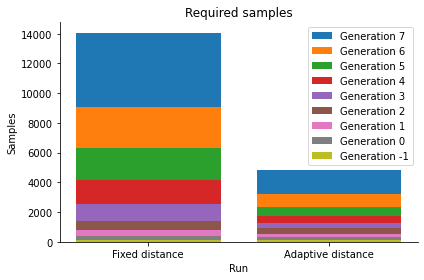

In [6]:
histories = [history0, history1]
labels = ["Fixed distance", "Adaptive distance"]
pyabc.visualization.plot_sample_numbers(histories, labels)

Indeed, the acceptance rates for the adaptive distance function are continually higher:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index $t$', ylabel='Acceptance rate'>

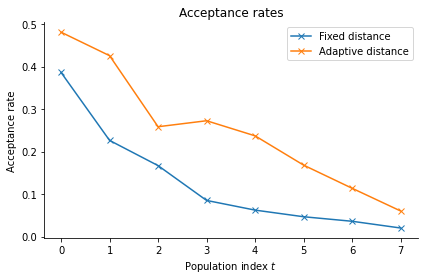

In [7]:
pyabc.visualization.plot_acceptance_rates_trajectory(histories, labels)

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. For instance, there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [8]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * np.random.normal(),
            'ss2': 2 + 0.01 * np.random.normal()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")


# plotting

def plot_history(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2021-05-09 23:19:30.144091>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.06233008e+00.
ABC INFO: Accepted: 100 / 183 = 5.4645e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.19603314e+00.
ABC INFO: Accepted: 100 / 266 = 3.7594e-01, ESS: 9.7366e+01.
ABC INFO: t: 2, eps: 3.05520886e+00.
ABC INFO: Accepted: 100 / 379 = 2.6385e-01, ESS: 8.8935e+01.
ABC INFO: t: 3, eps: 3.01993438e+00.
ABC INFO: Accepted: 100 / 569 = 1.7575e-01, ESS: 8.7627e+01.
ABC INFO: t: 4, eps: 3.00616870e+00.
ABC INFO: Accepted: 100 / 1085 = 9.2166e-02, ESS: 8.5538e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=3, duration=0:00:02.900649, end_time=2021-05-09 23:19:33.044740>


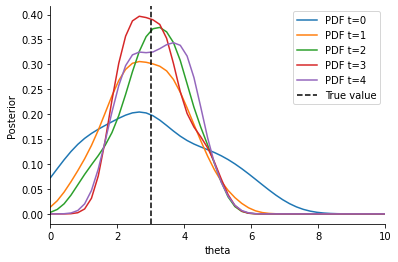

In [9]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history0)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2021-05-09 23:19:33.354463>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Weights[0] = {'ss1': 0.006371306562071415, 'ss2': 1.9936286934379286}
ABC INFO: t: 0, eps: 5.98004055e+00.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Weights[1] = {'ss1': 0.006997101019113868, 'ss2': 1.9930028989808863}
ABC INFO: t: 1, eps: 5.96404975e+00.
ABC INFO: Accepted: 100 / 479 = 2.0877e-01, ESS: 9.7913e+01.
ABC.Distance DEBUG: Weights[2] = {'ss1': 0.006899440402335037, 'ss2': 1.993100559597665}
ABC INFO: t: 2, eps: 5.95502958e+00.
ABC INFO: Accepted: 100 / 1011 = 9.8912e-02, ESS: 9.6486e+01.
ABC.Distance DEBUG: Weights[3] = {'ss1': 0.006261276063613269, 'ss2': 1.9937387239363868}
ABC INFO: t: 3, eps: 5.94993937e+00.
ABC INFO: Accepted: 100 / 1838 = 5.4407e-02, ESS: 9.6676e+01.
ABC.Distance DEBUG: Weights[4] = {'ss1': 0.006411864366491559, 'ss2': 1.993588

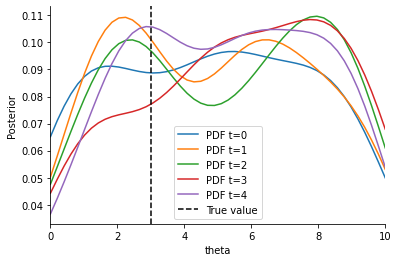

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.UniformAcceptor(use_complete_history=True))
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history1)

These results are as expected: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take the bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=5, start_time=2021-05-09 23:19:38.674761>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Weights[0] = {'ss1': 0.8701512589947095, 'ss2': 1.1298487410052906}
ABC INFO: t: 0, eps: 4.21650555e+00.
ABC INFO: Accepted: 100 / 181 = 5.5249e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Weights[1] = {'ss1': 0.8838022545276886, 'ss2': 1.1161977454723115}
ABC INFO: t: 1, eps: 3.51092510e+00.
ABC INFO: Accepted: 100 / 224 = 4.4643e-01, ESS: 9.8001e+01.
ABC.Distance DEBUG: Weights[2] = {'ss1': 1.209555572360316, 'ss2': 0.7904444276396841}
ABC INFO: t: 2, eps: 2.46673908e+00.
ABC INFO: Accepted: 100 / 319 = 3.1348e-01, ESS: 9.2536e+01.
ABC.Distance DEBUG: Weights[3] = {'ss1': 1.3215477396854363, 'ss2': 0.6784522603145636}
ABC INFO: t: 3, eps: 2.06810074e+00.
ABC INFO: Accepted: 100 / 672 = 1.4881e-01, ESS: 8.8981e+01.
ABC.Distance DEBUG: Weights[4] = {'ss1': 1.3575991967855787, 'ss2': 0.6424008032144212}


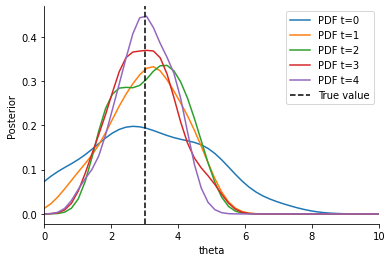

In [11]:
distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.UniformAcceptor(use_complete_history=True))
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history2)

In this setting, the accuracy and sample numbers (see below) are rougly back to the non-weighted case. Applying this method to the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

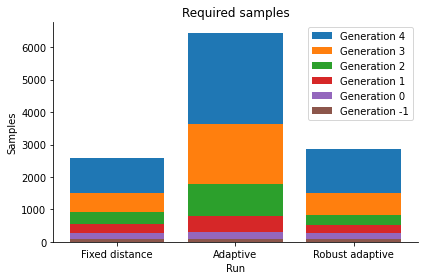

In [12]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Weight diverse data with replicates

The problem we consider now is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative. At the moment, these factors still need to be defined manually.

Let us consider a toy model, where we just copy a single summary statistic N0=100 times. Note that this model is highly artificical, as in practise there might be more information contained in e.g. a time series than in a single measurement, but not N0 times as much, such that a good factor would be somewhere between 1 and N0.

In [13]:
import pyabc
import numpy as np
import os
import tempfile
import matplotlib.pyplot as plt
import logging

# for debugging
df_logger = logging.getLogger('ABC.Distance')
df_logger.setLevel(logging.INFO)

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * np.random.normal()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * np.random.normal()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

First, we consider uniform weights of 1:

In [14]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=8)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=6, start_time=2021-05-09 23:19:42.738170>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 5.11371105e+02.
ABC INFO: Accepted: 100 / 250 = 4.0000e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.48920322e+02.
ABC INFO: Accepted: 100 / 239 = 4.1841e-01, ESS: 8.3668e+01.
ABC INFO: t: 2, eps: 1.18358751e+02.
ABC INFO: Accepted: 100 / 369 = 2.7100e-01, ESS: 9.3646e+01.
ABC INFO: t: 3, eps: 5.94580373e+01.
ABC INFO: Accepted: 100 / 732 = 1.3661e-01, ESS: 7.6421e+01.
ABC INFO: t: 4, eps: 3.02386442e+01.
ABC INFO: Accepted: 100 / 1576 = 6.3452e-02, ESS: 8.1818e+01.
ABC INFO: t: 5, eps: 1.93412574e+01.
ABC INFO: Accepted: 100 / 2168 = 4.6125e-02, ESS: 6.0460e+01.
ABC INFO: t: 6, eps: 1.32096225e+01.
ABC INFO: Accepted: 100 / 4239 = 2.3590e-02, ESS: 3.7151e+01.
ABC INFO: t: 7, eps: 9.30940997e+00.
ABC INFO: Accepted: 100 / 8349 = 1.1977e-02, ESS: 2.3446e+00.
ABC INFO: Stop: Maximum number of generatio

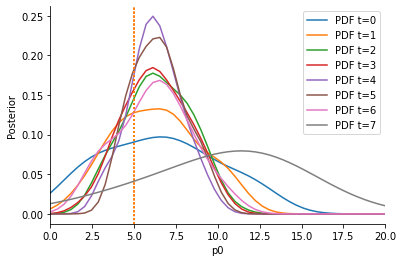

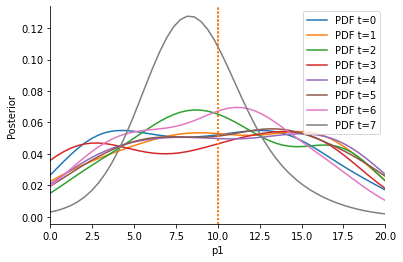

In [15]:
# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

Next, we use adaptive distances but no factors:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=7, start_time=2021-05-09 23:20:33.931392>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.03288947e+02.
ABC INFO: Accepted: 100 / 281 = 3.5587e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.12901613e+02.
ABC INFO: Accepted: 100 / 246 = 4.0650e-01, ESS: 9.5420e+01.
ABC INFO: t: 2, eps: 1.14390142e+02.
ABC INFO: Accepted: 100 / 442 = 2.2624e-01, ESS: 6.2348e+01.
ABC INFO: t: 3, eps: 4.61596394e+01.
ABC INFO: Accepted: 100 / 896 = 1.1161e-01, ESS: 8.4757e+01.
ABC INFO: t: 4, eps: 2.23650921e+01.
ABC INFO: Accepted: 100 / 1749 = 5.7176e-02, ESS: 6.7059e+01.
ABC INFO: t: 5, eps: 1.32214768e+01.
ABC INFO: Accepted: 100 / 3553 = 2.8145e-02, ESS: 8.7260e+01.
ABC INFO: t: 6, eps: 8.83897852e+00.
ABC INFO: Accepted: 100 / 4961 = 2.0157e-02, ESS: 2.5811e+01.
ABC INFO: t: 7, eps: 5.25277040e+00.
ABC INFO: Accepted: 100 / 15176 = 6.5894e-03, ESS: 6.8180e+01.
ABC INFO: Stop: Maximum number of generati

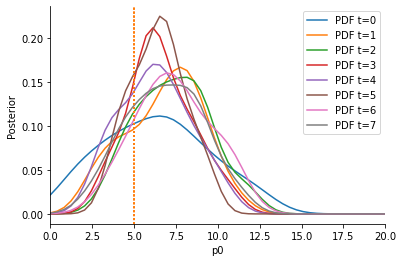

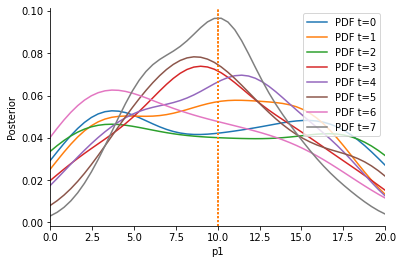

In [16]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=8)

plot_history(history2)

Next, we account for the discrepancy in data point counts by using self-defined scaling factors:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=8, start_time=2021-05-09 23:21:20.846485>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.13233912e+01.
ABC INFO: Accepted: 100 / 200 = 5.0000e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 8.03354843e+00.
ABC INFO: Accepted: 100 / 180 = 5.5556e-01, ESS: 9.7311e+01.
ABC INFO: t: 2, eps: 6.39544762e+00.
ABC INFO: Accepted: 100 / 230 = 4.3478e-01, ESS: 8.5177e+01.
ABC INFO: t: 3, eps: 4.29136907e+00.
ABC INFO: Accepted: 100 / 279 = 3.5842e-01, ESS: 9.3453e+01.
ABC INFO: t: 4, eps: 2.90863385e+00.
ABC INFO: Accepted: 100 / 302 = 3.3113e-01, ESS: 8.7685e+01.
ABC INFO: t: 5, eps: 2.07252430e+00.
ABC INFO: Accepted: 100 / 303 = 3.3003e-01, ESS: 6.5088e+01.
ABC INFO: t: 6, eps: 1.64163668e+00.
ABC INFO: Accepted: 100 / 446 = 2.2422e-01, ESS: 7.4993e+01.
ABC INFO: t: 7, eps: 1.11140837e+00.
ABC INFO: Accepted: 100 / 831 = 1.2034e-01, ESS: 7.9614e+01.
ABC INFO: Stop: Maximum number of generations.


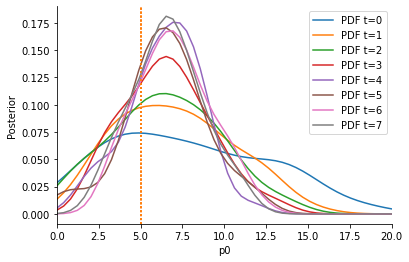

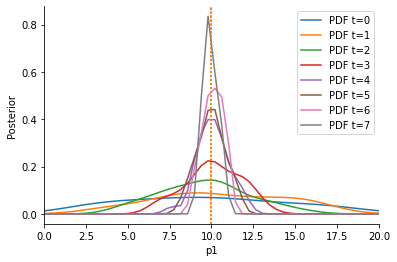

In [17]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=8)

plot_history(history3)

Next, we consider automatic weighting and factors:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=9, start_time=2021-05-09 23:21:51.119500>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.07389905e+01.
ABC INFO: Accepted: 100 / 198 = 5.0505e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.30258324e+00.
ABC INFO: Accepted: 100 / 240 = 4.1667e-01, ESS: 9.7387e+01.
ABC INFO: t: 2, eps: 5.23235485e+00.
ABC INFO: Accepted: 100 / 236 = 4.2373e-01, ESS: 8.5003e+01.
ABC INFO: t: 3, eps: 3.51759027e+00.
ABC INFO: Accepted: 100 / 307 = 3.2573e-01, ESS: 7.1706e+01.
ABC INFO: t: 4, eps: 3.38343410e+00.
ABC INFO: Accepted: 100 / 362 = 2.7624e-01, ESS: 9.0590e+01.
ABC INFO: t: 5, eps: 2.88066618e+00.
ABC INFO: Accepted: 100 / 379 = 2.6385e-01, ESS: 8.8564e+01.
ABC INFO: t: 6, eps: 2.26202652e+00.
ABC INFO: Accepted: 100 / 416 = 2.4038e-01, ESS: 8.7727e+01.
ABC INFO: t: 7, eps: 1.90991888e+00.
ABC INFO: Accepted: 100 / 455 = 2.1978e-01, ESS: 8.0749e+01.
ABC INFO: Stop: Maximum number of generations.


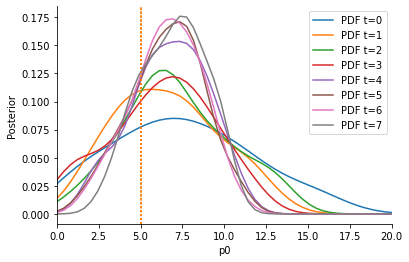

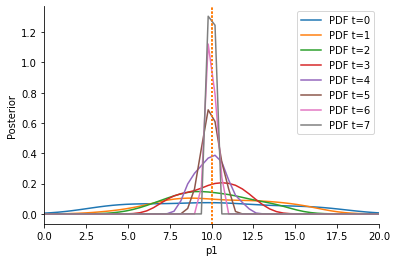

In [18]:
import logging
df_logger = logging.getLogger('ABC.Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=8)

plot_history(history4)

The results for the distances that re-factor are best, and in this case fixed and adaptive weights give similar results. In addition to the much better posteriors, the sample numbers are much lower, as the below plots show.

<AxesSubplot:title={'center':'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

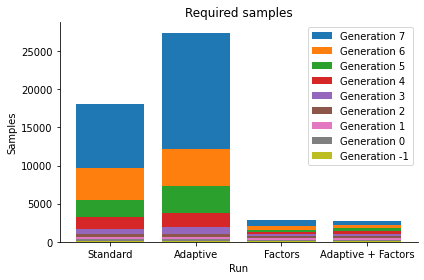

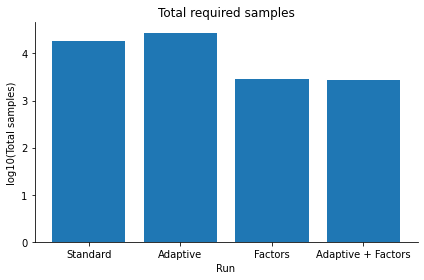

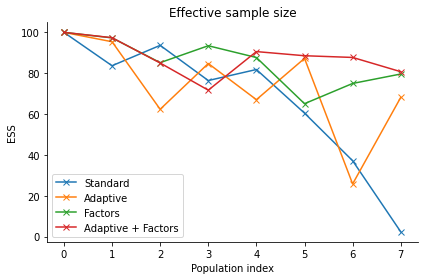

In [19]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)